In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]

In [3]:
# The pre-trained model that OpenCV uses has been trained in Caffe framework
#Download from the link above
protoPath = "hed_model/deploy.prototxt"
modelPath = "hed_model/hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

In [4]:
# register our crop layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)

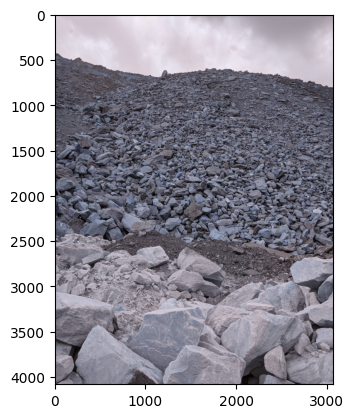

In [5]:
# load the input image and grab its dimensions, for future use while defining the blob
img = cv2.imread("a.jpg")
plt.imshow(img)
(H, W) = img.shape[:2]


In [6]:
# construct a blob out of the input image 
#blob is basically preprocessed image. 
#OpenCV’s new deep neural network (dnn ) module contains two functions that 
#can be used for preprocessing images and preparing them for 
#classification via pre-trained deep learning models.
# It includes scaling and mean subtraction
#How to calculate the mean?
mean_pixel_values= np.average(img, axis = (0,1))
blob = cv2.dnn.blobFromImage(img, scalefactor=0.7, size=(W, H),
                             mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                             #mean=(105, 117, 123),
                             swapRB= False, crop=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


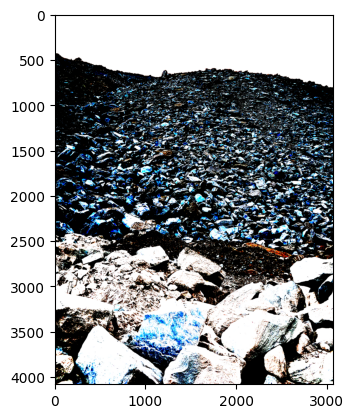

In [7]:
#View image after preprocessing (blob)
blob_for_plot = np.moveaxis(blob[0,:,:,:], 0,2)
plt.imshow(blob_for_plot)

In [8]:
# set the blob as the input to the network and perform a forward pass
# to compute the edges
net.setInput(blob)
hed = net.forward()
hed = hed[0,0,:,:]  #Drop the other axes 
#hed = cv2.resize(hed[0, 0], (W, H))
hed = (255 * hed).astype("uint8")  #rescale to 0-255

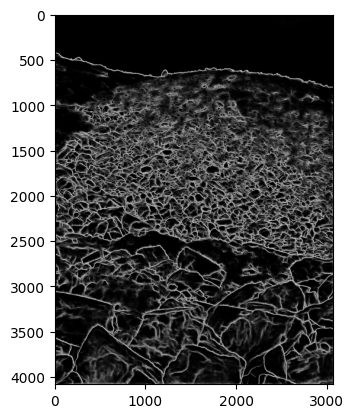

In [9]:
plt.imshow(hed, cmap='gray')

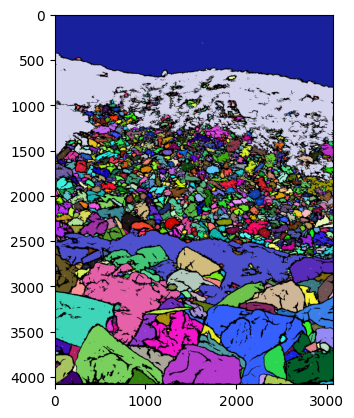

In [10]:
####################
#Connected component based labeling

# Load segmented binary image, Gaussian blur, grayscale, Otsu's threshold
blur = cv2.GaussianBlur(hed, (3,3), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

# Perform connected component labeling
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)

# Create false color image with black background and colored objects
colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
colors[0] = [0, 0, 0]  # black background
false_colors = colors[labels]
plt.imshow(false_colors)

# Obtain centroids
false_colors_centroid = false_colors.copy()
for centroid in centroids:
    cv2.drawMarker(false_colors_centroid, (int(centroid[0]), int(centroid[1])),
                   color=(255, 255, 255), markerType=cv2.MARKER_CROSS)
plt.imshow(false_colors_centroid)

In [11]:
# Remove small objects
MIN_AREA = 50
false_colors_area_filtered = false_colors.copy()
for i, centroid in enumerate(centroids[1:], start=1):
    area = stats[i, 4]
    if area > MIN_AREA:
        cv2.drawMarker(false_colors_area_filtered, (int(centroid[0]), int(centroid[1])),
                       color=(255, 255, 255), markerType=cv2.MARKER_CROSS)

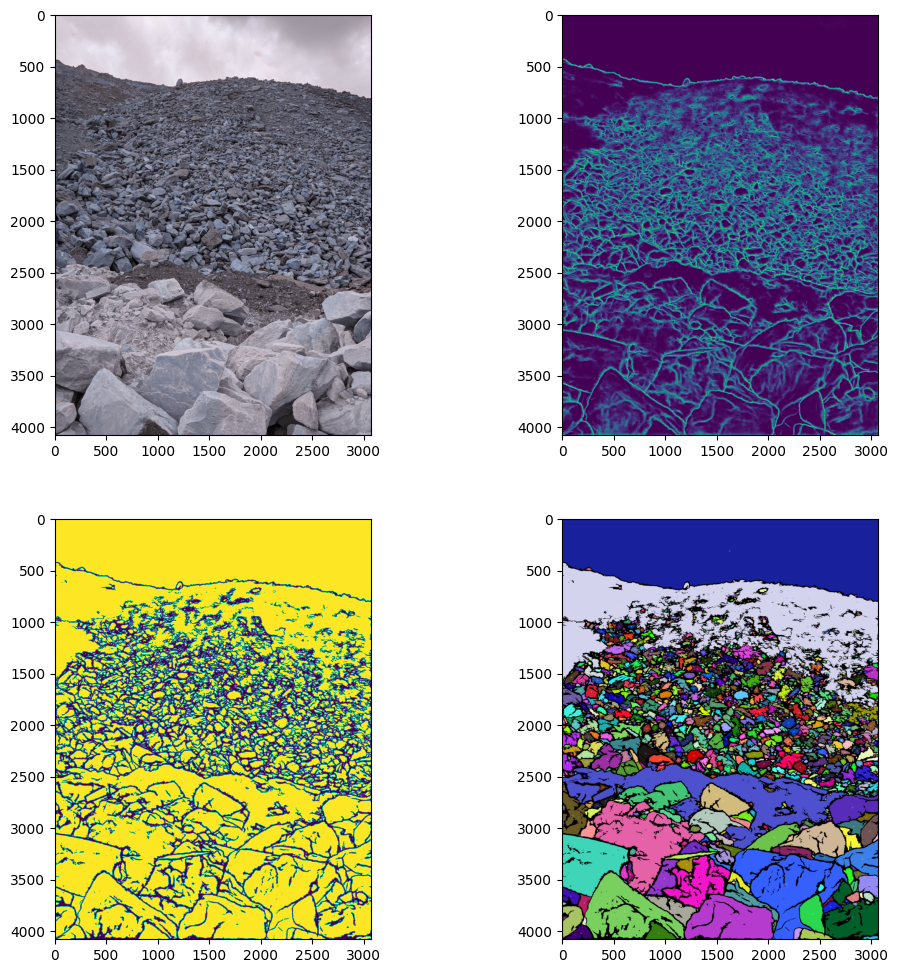

In [12]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(hed)
plt.subplot(223)
plt.imshow(thresh)
plt.subplot(224)
plt.imshow(false_colors_area_filtered) 
plt.show()

In [13]:
############################
#Alternatively, We can also use regionprops from skimage to extract various parameters

# regionprops function in skimage measure module calculates useful parameters for each object.
from skimage import measure
props = measure.regionprops_table(labels, intensity_image=img, 
                              properties=['label',
                                          'area', 'equivalent_diameter',
                                          'mean_intensity', 'solidity'])

In [14]:
# Perform connected component labeling
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)
count=0
label_area_dict = {}
# Iterate over each labeled region
for label in range(1, n_labels):
    area = stats[label, cv2.CC_STAT_AREA]
    if area >= 1000:
        print(f"Segment {label}: Pixel Count = {area}")
        count=count+1
        # Save label and area in the dictionary
        label_area_dict[label] = area

print(count,label_area_dict)

Segment 1: Pixel Count = 1940534
Segment 2: Pixel Count = 1686830
Segment 12: Pixel Count = 1535
Segment 146: Pixel Count = 1117
Segment 152: Pixel Count = 1109
Segment 180: Pixel Count = 1676
Segment 192: Pixel Count = 1733
Segment 198: Pixel Count = 1020
Segment 225: Pixel Count = 3421
Segment 231: Pixel Count = 1258
Segment 237: Pixel Count = 1231
Segment 245: Pixel Count = 1878
Segment 292: Pixel Count = 1489
Segment 311: Pixel Count = 1538
Segment 318: Pixel Count = 2312
Segment 330: Pixel Count = 3368
Segment 363: Pixel Count = 6103
Segment 367: Pixel Count = 1462
Segment 375: Pixel Count = 3509
Segment 395: Pixel Count = 1247
Segment 402: Pixel Count = 1796
Segment 410: Pixel Count = 1498
Segment 413: Pixel Count = 1047
Segment 431: Pixel Count = 1425
Segment 447: Pixel Count = 1709
Segment 467: Pixel Count = 1250
Segment 468: Pixel Count = 1566
Segment 475: Pixel Count = 14176
Segment 492: Pixel Count = 15761
Segment 501: Pixel Count = 3717
Segment 527: Pixel Count = 1442
Segme

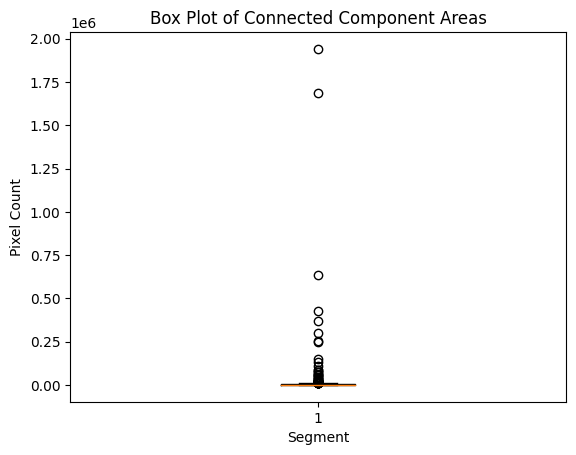

In [15]:
import matplotlib.pyplot as plt

# Assuming you have already created the 'label_area_dict' as shown in the previous code

# Extract the areas from the dictionary
areas = list(label_area_dict.values())

# Create a box plot
plt.boxplot(areas)

# Add labels and title
plt.xlabel('Segment')
plt.ylabel('Pixel Count')
plt.title('Box Plot of Connected Component Areas')

# Display the plot
plt.show()


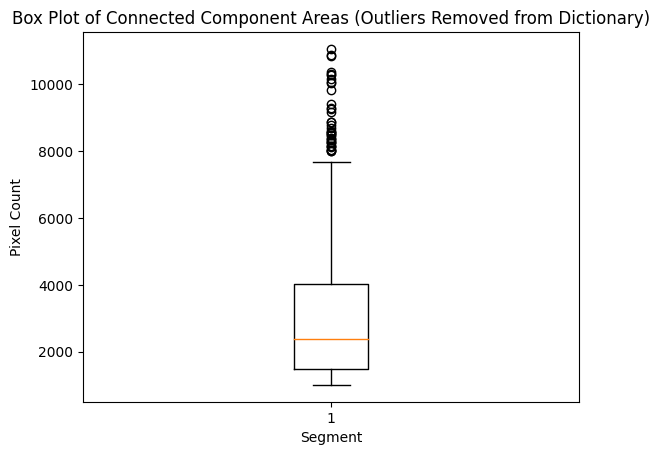

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already created the 'label_area_dict' as shown in the previous code

# Extract the areas from the dictionary
areas = list(label_area_dict.values())

# Calculate the first and third quartiles (Q1 and Q3)
q1, q3 = np.percentile(areas, [25, 75])

# Calculate the Interquartile Range (IQR)
iqr = q3 - q1

# Define the upper and lower bounds for outlier detection
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# Remove the outliers from the dictionary
label_area_dict = {label: area for label, area in label_area_dict.items() if lower_bound <= area <= upper_bound}

# Create a box plot of the filtered data
plt.boxplot(list(label_area_dict.values()))

# Add labels and title
plt.xlabel('Segment')
plt.ylabel('Pixel Count')
plt.title('Box Plot of Connected Component Areas (Outliers Removed from Dictionary)')

# Display the plot
plt.show()


In [17]:
max_area = max(label_area_dict.values())

# Print the maximum value
print("Maximum Area:", max_area)

Maximum Area: 11048


In [18]:
import cv2
import numpy as np

# Perform connected component labeling
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)

# Assuming you already have the 'label_area_dict' dictionary with segment labels and their areas

# Iterate over each labeled region
for label in range(1, n_labels):
    area = stats[label, cv2.CC_STAT_AREA]
    
    # Check if the area of the current region is greater than or equal to 1000 and exists in 'label_area_dict'
    if area >= 1000 and label in label_area_dict:
        # Create an image with the same size as the original image, filled with zeros
        segment_image = np.zeros_like(img)
        
        # Get the bounding box coordinates of the current region
        x, y, width, height = stats[label, cv2.CC_STAT_LEFT], stats[label, cv2.CC_STAT_TOP], \
                              stats[label, cv2.CC_STAT_WIDTH], stats[label, cv2.CC_STAT_HEIGHT]
        
        # Get the mask for the current region (1 for the region, 0 for the rest)
        segment_mask = (labels[y:y+height, x:x+width] == label).astype(np.uint8)
        
        # Expand the mask to have the same number of channels as the original image
        segment_mask_expanded = np.expand_dims(segment_mask, axis=-1)
        
        # Copy the pixels of the current region from the original image to the segment image
        segment_image[y:y+height, x:x+width] = img[y:y+height, x:x+width] * segment_mask_expanded
        
        # Save the segmented image to disk
        cv2.imwrite(f'segment_data/segment_{label}.png', segment_image)


In [ ]:
import numpy as np
from sklearn.cluster import KMeans


# Extract the areas from the dictionary
areas = np.array(list(label_area_dict.values())).reshape(-1, 1)

# Define the number of clusters (3 in this case)
num_clusters = 3

# Apply k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(areas)

# Get the cluster centers (average areas of each cluster)
cluster_centers = kmeans.cluster_centers_.flatten()

# Sort the cluster centers to get the ascending order of areas
sorted_cluster_centers = np.sort(cluster_centers)

# Create a mapping dictionary for cluster labels to their corresponding size categories
size_category_mapping = {
    cluster_id: category
    for cluster_id, category in enumerate(['small', 'big', 'large'])
}

# Apply the mapping to the 'label_area_dict' to assign size categories to each segment
label_size_categories = {
    label: size_category_mapping.get(cluster_id, 'N/A')
    for label, cluster_id in zip(label_area_dict.keys(), kmeans.predict(areas))
}
cluster={}
# Print the size categories of each segment
for label, size_category in label_size_categories.items():
    print(f"Segment {label}: Size Category = {size_category}")
    cluster


d:\venv\FLA\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Segment 12: Size Category = big
Segment 146: Size Category = big
Segment 152: Size Category = big
Segment 180: Size Category = big
Segment 192: Size Category = big
Segment 198: Size Category = big
Segment 225: Size Category = large
Segment 231: Size Category = big
Segment 237: Size Category = big
Segment 245: Size Category = big
Segment 292: Size Category = big
Segment 311: Size Category = big
Segment 318: Size Category = big
Segment 330: Size Category = large
Segment 363: Size Category = large
Segment 367: Size Category = big
Segment 375: Size Category = large
Segment 395: Size Category = big
Segment 402: Size Category = big
Segment 410: Size Category = big
Segment 413: Size Category = big
Segment 431: Size Category = big
Segment 447: Size Category = big
Segment 467: Size Category = big
Segment 468: Size Category = big
Segment 501: Size Category = large
Segment 527: Size Category = big
Segment 528: Size Category = big
Segment 540: Size Category = big
Segment 559: Size Category = big
S

In [ ]:
cluster={}
# Print the size categories of each segment
for label, size_category in label_size_categories.items():
    print(f"Segment {label}: Size Category = {size_category}")
    cluster[label]= size_category

Segment 12: Size Category = big
Segment 146: Size Category = big
Segment 152: Size Category = big
Segment 180: Size Category = big
Segment 192: Size Category = big
Segment 198: Size Category = big
Segment 225: Size Category = large
Segment 231: Size Category = big
Segment 237: Size Category = big
Segment 245: Size Category = big
Segment 292: Size Category = big
Segment 311: Size Category = big
Segment 318: Size Category = big
Segment 330: Size Category = large
Segment 363: Size Category = large
Segment 367: Size Category = big
Segment 375: Size Category = large
Segment 395: Size Category = big
Segment 402: Size Category = big
Segment 410: Size Category = big
Segment 413: Size Category = big
Segment 431: Size Category = big
Segment 447: Size Category = big
Segment 467: Size Category = big
Segment 468: Size Category = big
Segment 501: Size Category = large
Segment 527: Size Category = big
Segment 528: Size Category = big
Segment 540: Size Category = big
Segment 559: Size Category = big
S

In [ ]:
print(cluster)

{12: 'big', 146: 'big', 152: 'big', 180: 'big', 192: 'big', 198: 'big', 225: 'large', 231: 'big', 237: 'big', 245: 'big', 292: 'big', 311: 'big', 318: 'big', 330: 'large', 363: 'large', 367: 'big', 375: 'large', 395: 'big', 402: 'big', 410: 'big', 413: 'big', 431: 'big', 447: 'big', 467: 'big', 468: 'big', 501: 'large', 527: 'big', 528: 'big', 540: 'big', 559: 'big', 608: 'big', 614: 'big', 618: 'small', 633: 'big', 646: 'large', 649: 'big', 652: 'big', 677: 'big', 691: 'big', 693: 'large', 697: 'big', 711: 'small', 745: 'big', 752: 'big', 756: 'large', 781: 'big', 791: 'big', 792: 'large', 811: 'big', 817: 'big', 829: 'large', 831: 'large', 836: 'large', 843: 'big', 855: 'large', 883: 'big', 893: 'big', 905: 'big', 910: 'big', 912: 'big', 924: 'large', 931: 'big', 939: 'big', 957: 'large', 969: 'big', 975: 'big', 985: 'large', 994: 'small', 1012: 'big', 1025: 'big', 1030: 'big', 1035: 'large', 1046: 'big', 1053: 'big', 1056: 'small', 1073: 'large', 1074: 'big', 1079: 'big', 1084: 'big

In [ ]:
segmented_image = np.zeros_like(img)

# Iterate over each labeled region
for label in range(1, n_labels):
    area = stats[label, cv2.CC_STAT_AREA]
    
    # Check if the area of the current region is greater than or equal to 1000 and exists in 'label_area_dict'
    if area >= 1000 and label in label_area_dict:
        # Get the bounding box coordinates of the current region
        x, y, width, height = stats[label, cv2.CC_STAT_LEFT], stats[label, cv2.CC_STAT_TOP], \
                              stats[label, cv2.CC_STAT_WIDTH], stats[label, cv2.CC_STAT_HEIGHT]
        
        # Get the mask for the current region (1 for the region, 0 for the rest)
        segment_mask = (labels[y:y+height, x:x+width] == label).astype(np.uint8)
        
        # Get the size category of the current segment
        size_category = cluster[label]
        
        # Get the corresponding color based on the size category and convert it to uint8
        if size_category == 'small':
            color = np.array([0, 255, 0], dtype=np.uint8)  # Green for small
        elif size_category == 'big':
            color = np.array([0, 0, 255], dtype=np.uint8)  # Red for big
        elif size_category == 'large':
            color = np.array([255, 0, 0], dtype=np.uint8)  # Blue for large
        else:
            color = np.array([255, 255, 255], dtype=np.uint8)  # White for 'N/A'
        
        # Expand the segment_mask to have three channels (R, G, B)
        segment_mask_expanded = np.expand_dims(segment_mask, axis=-1)
        segment_mask_expanded = np.tile(segment_mask_expanded, (1, 1, 3))
        
        # Create a colored rectangle around the current segment in the segmented image
        segmented_image[y:y+height, x:x+width] += img[y:y+height, x:x+width] * segment_mask_expanded + color * (1 - segment_mask_expanded)

# Display the segmented image
# Save the segmented image
cv2.imwrite('selective_segment.png', segmented_image)

True